# Gene-to-graph workflow

This notebook showcases the steps to generate the BioDataFuse data and graph serializations from a list of genes.


In [1]:
# Setting up the working directory
import os
import time

start_time = time.time()
current_dir = os.getcwd()

os.chdir(os.path.join(f"{current_dir}", ".."))

# Set the current working directory
current_dir = os.getcwd()
print("Current directory:", current_dir)

Current directory: /home/javi/pyBiodatafuse-1


In [2]:
# Import modules
import pickle

import pandas as pd
from IPython.display import Image, display

from pyBiodatafuse import id_mapper
from pyBiodatafuse.annotators import (
    bgee,
    disgenet,
    minerva,
    molmedb,
    opentargets,
    pubchem,
    stringdb,
    wikipathways,
)
from pyBiodatafuse.constants import DISGENET_DISEASE_COL
from pyBiodatafuse.graph import generator
from pyBiodatafuse.graph.rdf import BDFGraph
from pyBiodatafuse.utils import (
    combine_sources,
    create_harmonized_input_file,
    create_or_append_to_metadata,
)

## 1. Entity resolution with BridgeDB

The first step is to input the list of genes to query and retrieve their protein target and synonym identifiers using BridgeDB.

### 1.1. Load the input list and convert it to a dataframe

In [3]:
genes_of_interest = """SETD1A
CUL1
XPO7
GRIA3
GRIN2A
RB1CC1
"""

gene_list = genes_of_interest.split("\n")
data_input = pd.DataFrame(gene_list, columns=["identifier"])
data_input.head()

,identifier
0,SETD1A
1,CUL1
2,XPO7
3,GRIA3
4,GRIN2A


### 1.2. Query BridgeDB
The results will be stored in the following directories:

In [4]:
os.makedirs(os.path.join("examples", "data"), exist_ok=True)  # TODO paths
os.makedirs(os.path.join("examples", "data", "gene_to_graph_workflow"), exist_ok=True)

In [5]:
base_dir = os.path.abspath(os.getcwd())  # Ensures an absolute path
pickle_path = os.path.join(base_dir, "examples", "data", "example_gene_list.pkl")
metadata_path = os.path.join(base_dir, "examples", "data", "example_gene_list_metadata.pkl")

if not os.path.exists(pickle_path):
    bridgedb_df, bridgedb_metadata = id_mapper.bridgedb_xref(
        identifiers=data_input,
        input_species="Human",
        input_datasource="HGNC",
        output_datasource="All",
    )
    bridgedb_df.to_pickle(pickle_path)
    with open(metadata_path, "wb") as file:
        pickle.dump(bridgedb_metadata, file)
else:
    bridgedb_df = pd.read_pickle(pickle_path)
    with open(metadata_path, "rb") as file:
        bridgedb_metadata = pickle.load(file)

In [6]:
print("Number of genes with mapping in BridgeDb:", len(bridgedb_df["identifier"].unique()))
bridgedb_df.head()

Number of genes with mapping in BridgeDb: 6


,identifier,identifier.source,target,target.source
0,SETD1A,HGNC,C9J2Z9,Uniprot-TrEMBL
1,SETD1A,HGNC,ENSG00000099381,Ensembl
2,SETD1A,HGNC,HGNC:29010,HGNC Accession Number
3,SETD1A,HGNC,SETD1A,HGNC
4,SETD1A,HGNC,9739,NCBI Gene


## 2. Gene expression
### 2.1. Gene expression from Bgee

In [7]:
bgee_path = os.path.join(base_dir, "examples", "data", "example_bgee.pkl")
bgee_metadata_path = os.path.join(base_dir, "examples", "data", "example_bgee_metadata.pkl")

if not os.path.exists(bgee_path):
    bgee_df, bgee_metadata = bgee.get_gene_expression(bridgedb_df=bridgedb_df)
    bgee_df.to_pickle(bgee_path)
    with open(bgee_metadata_path, "wb") as file:
        pickle.dump(bgee_metadata, file)
else:
    bgee_df = pd.read_pickle(bgee_path)
    with open(bgee_metadata_path, "rb") as file:
        bgee_metadata = pickle.load(file)

## 3. Disease annotation
### 3.1. Gene to disease annotation with DisGeNET

In [8]:
#import dotenv

#disgenet_api_key = dotenv.dotenv_values(".env")["DISGENET_API_KEY"]

In [9]:
disgenet_path = os.path.join(base_dir, "examples", "data", "example_disgenet.pkl")
disgenet_metadata_path = os.path.join(base_dir, "examples", "data", "example_disgenet_metadata.pkl")


if not os.path.exists(disgenet_path):
    disgenet_df, disgenet_metadata = disgenet.get_gene_disease(
        api_key=disgenet_api_key, bridgedb_df=bridgedb_df
    )

    disgenet_df.to_pickle(disgenet_path)
    with open(disgenet_metadata_path, "wb") as file:
        pickle.dump(disgenet_metadata, file)
else:
    disgenet_df = pd.read_pickle(disgenet_path)
    with open(disgenet_metadata_path, "rb") as file:
        disgenet_metadata = pickle.load(file)

NameError: name 'disgenet_api_key' is not defined

### 3.2. Disease to compound annotation from OpenTargets

In [ ]:
# Prepare the input to use DISGENET output as seed for OpenTargets
disease_mapping_df = create_harmonized_input_file(disgenet_df, DISGENET_DISEASE_COL, "EFO", "UMLS")
disease_mapping_df.head()

In [ ]:
opentarget_path = os.path.join(base_dir, "examples", "data", "example_opentarget_cmpd.pkl")
opentarget_metadata_path = os.path.join(
    base_dir, "examples", "data", "example_opentarget_cmpd_metadata.pkl"
)


if not os.path.exists(opentarget_path):
    opentargets_df, opentargets_metadata = opentargets.get_disease_compound_interactions(
        disease_mapping_df
    )
    opentargets_df.to_pickle(opentarget_path)
    with open(opentarget_metadata_path, "wb") as file:
        pickle.dump(opentargets_metadata, file)
else:
    opentargets_df = pd.read_pickle(opentarget_path)
    with open(opentarget_metadata_path, "rb") as file:
        opentargets_metadata = pickle.load(file)

## 4. Pathways and Gene Ontology terms
### 4.1. Pathways from MINERVA

In [10]:
minerva_path = os.path.join(base_dir, "examples", "data", "example_minerva.pkl")
minerva_metadata_path = os.path.join(base_dir, "examples", "data", "example_minerva_metadata.pkl")


if not os.path.exists(minerva_path):
    minerva_df, minerva_metadata = minerva.get_gene_minerva_pathways(
        bridgedb_df, map_name="COVID19 Disease Map"
    )
    minerva_df.to_pickle(minerva_path)
    with open(minerva_metadata_path, "wb") as file:
        pickle.dump(minerva_metadata, file)

else:
    minerva_df = pd.read_pickle(minerva_path)
    with open(minerva_metadata_path, "rb") as file:
        minerva_metadata = pickle.load(file)

### 4.2. Pathways from WikiPathways

In [11]:
wikipathways_path = os.path.join(base_dir, "examples", "data", "example_wikipathway.pkl")
wikipathways_metadata_path = os.path.join(
    base_dir, "examples", "data", "example_wikipathway_metadata.pkl"
)


if not os.path.exists(wikipathways_path):
    wikipathways_df, wikipathways_metadata = wikipathways.get_gene_wikipathways(
        bridgedb_df=bridgedb_df
    )
    wikipathways_df.to_pickle(wikipathways_path)
    with open(wikipathways_metadata_path, "wb") as file:
        pickle.dump(wikipathways_metadata, file)

else:
    wikipathways_df = pd.read_pickle(wikipathways_path)
    with open(wikipathways_metadata_path, "rb") as file:
        wikipathways_metadata = pickle.load(file)

### 4.3. Reactome pathways from OpenTargets

In [12]:
opentargets_reactome_path = os.path.join(base_dir, "examples", "data", "example_ot_reactome.pkl")
opentargets_reactome_metadata_path = os.path.join(
    base_dir, "examples", "data", "example_ot_reactome_metadata.pkl"
)


if not os.path.exists(opentargets_reactome_path):
    opentargets_reactome_df, opentargets_reactome_metadata = opentargets.get_gene_reactome_pathways(
        bridgedb_df=bridgedb_df
    )
    opentargets_reactome_df.to_pickle(opentargets_reactome_path)
    with open(opentargets_reactome_metadata_path, "wb") as file:
        pickle.dump(opentargets_reactome_metadata, file)
else:
    opentargets_reactome_df = pd.read_pickle(opentargets_reactome_path)
    with open(opentargets_reactome_metadata_path, "rb") as file:
        opentargets_reactome_metadata = pickle.load(file)

### 4.4. Gene Ontology from OpenTargets

In [13]:
opentargets_go_path = os.path.join(base_dir, "examples", "data", "example_ot_go.pkl")
opentargets_go_metadata_path = os.path.join(
    base_dir, "examples", "data", "example_ot_go_metadata.pkl"
)


if not os.path.exists(opentargets_go_path):
    opentargets_go_df, opentargets_go_metadata = opentargets.get_gene_go_process(
        bridgedb_df=bridgedb_df
    )
    opentargets_go_df.to_pickle(opentargets_go_path)
    with open(opentargets_go_metadata_path, "wb") as file:
        pickle.dump(opentargets_go_metadata, file)
else:
    opentargets_go_df = pd.read_pickle(opentargets_go_path)
    with open(opentargets_go_metadata_path, "rb") as file:
        opentargets_go_metadata = pickle.load(file)

## 5. Compound annotation
### 5.1. Compound annotation from OpenTargets

In [14]:
opentargets_gene_path = os.path.join(base_dir, "examples", "data", "example_ot_gene_cmpd.pkl")
opentargets_gene_metadata_path = os.path.join(
    base_dir, "examples", "data", "example_ot_gene_cmpd_metadata.pkl"
)


if not os.path.exists(opentargets_gene_path):
    opentargets_compound_df, opentargets_compound_metadata = (
        opentargets.get_gene_compound_interactions(bridgedb_df=bridgedb_df)
    )
    opentargets_compound_df.to_pickle(opentargets_gene_path)
    with open(opentargets_gene_metadata_path, "wb") as file:
        pickle.dump(opentargets_compound_metadata, file)

else:
    opentargets_compound_df = pd.read_pickle(opentargets_gene_path)
    with open(opentargets_gene_metadata_path, "rb") as file:
        opentargets_compound_metadata = pickle.load(file)

### 5.2. Screening results of compounds on proteins encoded by genes annotation by PubChem

In [15]:
pubchem_path = os.path.join(base_dir, "examples", "data", "example_pubchem.pkl")
pubchem_metadata_path = os.path.join(base_dir, "examples", "data", "example_pubchem_metadata.pkl")

if not os.path.exists(pubchem_path):
    pubchem_assay_df, pubchem_assay_metadata = pubchem.get_protein_compound_screened(
        bridgedb_df=bridgedb_df
    )
    pubchem_assay_df.to_pickle(pubchem_path)
    with open(pubchem_metadata_path, "wb") as file:
        pickle.dump(pubchem_assay_metadata, file)

else:
    pubchem_assay_df = pd.read_pickle(pubchem_path)
    with open(pubchem_metadata_path, "rb") as file:
        pubchem_assay_metadata = pickle.load(file)

## 6. Membrane transport annotations
### 6.1 Transporter inhibitor annotation from MolMeDB

In [16]:
molmedb_path = os.path.join(base_dir, "examples", "data", "example_molmedb_gene_cmpd.pkl")
molmedb_metadata_path = os.path.join(
    base_dir, "examples", "data", "example_molmedb_gene_cmpd_metadata.pkl"
)

if not os.path.exists(molmedb_path):
    inhibitor_df, inhibitor_metadata = molmedb.get_gene_compound_inhibitor(bridgedb_df=bridgedb_df)
    inhibitor_df.to_pickle(molmedb_path)
    with open(molmedb_metadata_path, "wb") as file:
        pickle.dump(inhibitor_metadata, file)
else:
    inhibitor_df = pd.read_pickle(molmedb_path)
    with open(molmedb_metadata_path, "rb") as file:
        inhibitor_metadata = pickle.load(file)
inhibitor_df.head(1)

""


## 7. Protein-Protein Interactions

### 7.1. Protein-Protein Interactions from STRING

In [17]:
!rm examples/data/example_string*
string_path = os.path.join(base_dir, "examples", "data", "example_string.pkl")
string_metadata_path = os.path.join(base_dir, "examples", "data", "example_string_metadata.pkl")

if not os.path.exists(string_path):
    ppi_df, ppi_metadata = stringdb.get_ppi(bridgedb_df=bridgedb_df)
    ppi_df.to_pickle(string_path)
    with open(string_metadata_path, "wb") as file:
        pickle.dump(ppi_metadata, file)
else:
    ppi_df = pd.read_pickle(string_path)
    with open(string_metadata_path, "rb") as file:
        ppi_metadata = pickle.load(file)

https://rest.uniprot.org/idmapping/status/d90457d58f5d9a81ea99c81843983ed09a233596
{'ENSP00000481554': 'P42263', 'ENSP00000332549': 'Q12879'}


In [18]:
ppi_df.StringDB_ppi[3]

[{'stringdb_link_to': 'GRIN2A',
  'Ensembl': 'ENSP00000332549',
  'score': 0.886,
  'Ensembl_link': 'ENSP00000481554',
  'Uniprot-TrEMBL': 'Q12879',
  'Uniprot-TrEMBL_link': 'P42263'}]

## 8. Graph generation 

### 8.1. Combine all data and metadata

In [19]:
combined_df = combine_sources(
    bridgedb_df,
    [
        bgee_df,
        #disgenet_df,
        minerva_df,
        wikipathways_df,
        opentargets_reactome_df,
        opentargets_go_df,
        opentargets_compound_df,
        inhibitor_df,
        pubchem_assay_df,
        ppi_df,
    ],
)

In [20]:
combined_df.to_pickle(os.path.join(base_dir, "examples", "data", "combined_df.pkl"))

The following code chunk shuffles the DisGeNET-queried data before serializing the graphs and displaying them, as it is not open access.

In [21]:
# Shuffling the rows
import numpy as np

combined_df["DISGENET_diseases"] = combined_df["DISGENET_diseases"].apply(np.random.permutation)

KeyError: 'DISGENET_diseases'

In [25]:
combined_metadata = create_or_append_to_metadata(
    bridgedb_metadata,
    [
        bgee_metadata,
        #disgenet_metadata,
        #opentargets_metadata,
        opentargets_compound_metadata,
        inhibitor_metadata,
        pubchem_assay_metadata,
        ppi_metadata,
        wikipathways_metadata,
        minerva_metadata,
        opentargets_reactome_metadata,
        opentargets_go_metadata,
    ],
)

We export the combined (meta) data in pickle format:

In [26]:
combined_df.to_pickle(os.path.join(base_dir, "examples", "data", "example_df_shuffled.pkl"))
with open("example_metadata.pkl", "wb") as out:
    pickle.dump(combined_metadata, out)

### 8.2. Create a graph from the annotated dataframe

In [27]:
pygraph = generator.save_graph(
    combined_df=combined_df,
    combined_metadata=combined_metadata,
    disease_compound=opentargets_df,
    graph_name="examples",
    graph_dir="./data",
)

NameError: name 'opentargets_df' is not defined

#### 8.3. Cytoscape
Make sure that the Cytoscape is open.

In [26]:
# from pyBiodatafuse.graph import cytoscape

# cytoscape.load_graph(pygraph, network_name="Test network")

#### 8.4. Neo4j

In [27]:
from pyBiodatafuse.graph import neo4j

neo4j.save_graph_to_graphml(pygraph, "networkx_graph_test.graphml")

##### Steps to load the graph in Neo4j

- Add `.graphml` file in **import** subfolder of the DBMS folder
- Install apoc plugin
- Create `apoc.conf` file:
    ```
    apoc.trigger.enabled=true
    apoc.import.file.enabled=true
    apoc.export.file.enabled=true
    apoc.import.file.use_neo4j_config=true
    ```
- Add `apoc.conf` file to **conf** subfolder of the DBMS folder
- Open Neo4j Browser
- (Optionl, only run if you have imported a graph  before) Remove all the nodes before importing `.graphml` file

    ```MATCH (n) DETACH DELETE n```

- Import `.graphml` file

    ```call apoc.import.graphml('file:///networkx_graph_test.graphml',{readLabels:TRUE})```

- Add indexes after importing the graph for improving the performance of queries

    ```
    create index Gene for (n:Gene) on (n.node_type)
    create index Pathway for (n:Pathway) on (n.node_type)
    create index `Biological Process` for (n:`Biological Process`) on (n.node_type)
    create index `Molecular Function` for (n:`Molecular Function`) on (n.node_type)
    create index `Cellular Component` for (n:`Cellular Component`) on (n.node_type)
    create index Disease for (n:Disease) on (n.node_type)
    create index Compound for (n:Compound) on (n.node_type)
    create index `Side Effect` for (n:`Side Effect`) on (n.node_type)
    ```
    

- Count the number of each node type
    - total (```MATCH (n) RETURN count(n)```) 
        - Gene (```MATCH (n:Gene) RETURN count(n)```)
        - Pathway (```MATCH (n:Pathway) RETURN count(n)```)
            - WikiPathways (```MATCH (n:Pathway {source: "WikiPathways"}) RETURN count(n)```) 
            - OpenTargets, Reactome (```MATCH (n:Pathway {source: "OpenTargets"}) RETURN count(n)```) 
            - MINERVA (```MATCH (n:Pathway {source: "MINERVA"}) RETURN count(n)```) 
        - Biological Process (```MATCH (n:`Biological Process`) RETURN count(n)```) 
        - Molecular Function (```MATCH (n:`Molecular Function`) RETURN count(n)```) 
        - Cellular Component (```MATCH (n:`Cellular Component`) RETURN count(n)```) 
        - Disease (```MATCH (n:Disease) RETURN count(n)```) 
        - Compound (```MATCH (n:Compound) RETURN count(n)```)
        - Side Effect (```MATCH (n:`Side Effect`) RETURN count(n)```) 
- Count the number of each edge type
    - total (```MATCH ()-[r]->() RETURN count(r)```) 
        - interacts_with (```MATCH ()-[r:interacts_with]->() RETURN count(r)```) 
        - part_of (```MATCH ()-[r:part_of]->() RETURN count(r)```) 
            - WikiPathways (```MATCH ()-[r:part_of {source: "WikiPathways"}]->() RETURN count(r)```) 
            - OpenTargets, Reactome (```MATCH ()-[r:part_of {source: "OpenTargets"}]->() RETURN count(r)```) 
            - MINERVA (```MATCH ()-[r:part_of {source: "MINERVA"}]->() RETURN count(r)```) 
        - activates (```MATCH ()-[r:activates]->() RETURN count(r)```) 
        - treats (```MATCH ()-[r:treats]->() RETURN count(r)```) 
        - has_side_effect (```MATCH ()-[r:has_side_effect]->() RETURN count(r)```) 
        - inhibits (```MATCH ()-[r:inhibits]->() RETURN count(r)```) = 71
        - associated_with (```MATCH ()-[r:associated_with]->() RETURN count(r)```) 

- Export the graph as a `.csv` file

    ```call apoc.export.csv.all("networkx_graph_test.csv",{})```

#### 8.5. RDF

In [28]:
# Instantiate a BDFGraph
bdf = BDFGraph(
    base_uri="https://biodatafuse.org/example/",
    version_iri="https://biodatafuse.org/example/test.owl",
    orcid="https://orcid.org/0000-0002-4166-7093",
    author="Javier Millan Acosta",
)

bdf.generate_rdf(combined_df, combined_metadata)  # Generate the RDF from the (meta)data

Building RDF graph: 100%|██████████| 6/6 [00:00<00:00, 35.24it/s]

Link P42263
Prot Q12879
Link Q12879
Prot P42263


In [29]:
bdf.serialize(
    os.path.join(base_dir, "examples", "data", "gene_to_graph_workflow", "BDF_example_graph.ttl"),
    format="ttl",
)

<Graph identifier=N1670b8571a364a559bfb679241cfc3a3 (<class 'pyBiodatafuse.graph.rdf.rdf.BDFGraph'>)>

In [30]:
os.getcwd()

'/home/javi/pyBiodatafuse-1'

In [31]:
bridgedb_df

,identifier,identifier.source,target,target.source
0,SETD1A,HGNC,C9J2Z9,Uniprot-TrEMBL
1,SETD1A,HGNC,ENSG00000099381,Ensembl
2,SETD1A,HGNC,HGNC:29010,HGNC Accession Number
3,SETD1A,HGNC,SETD1A,HGNC
4,SETD1A,HGNC,9739,NCBI Gene
...,...,...,...,...
57,RB1CC1,HGNC,E5RHX0,Uniprot-TrEMBL
58,RB1CC1,HGNC,E5RJC1,Uniprot-TrEMBL
59,RB1CC1,HGNC,9821,NCBI Gene
60,RB1CC1,HGNC,E5RH63,Uniprot-TrEMBL


##### 8.5.1. Generate prefixes SHACL

SHACL graphs defining namespaces and prefixes can be loaded into SPARQL endpoints to avoid having to declare prefixes in the query.

In [32]:
# Use without parameters (defaults, does not save file)
bdf.shacl_prefixes()
# or Use with parameters
bdf.shacl_prefixes(
    path=os.path.join(base_dir, "examples", "data", "gene_to_graph_workflow", "BDF_prefixes.ttl"),
    namespaces=None,  # Optional, add more namespaces with a dictionary of {prefix:namespace,}
)

@prefix sh: <http://www.w3.org/ns/shacl#> .
@prefix xsd: <http://www.w3.org/2001/XMLSchema#> .

[] sh:declare [ sh:namespace "http://xmlns.com/foaf/0.1/"^^xsd:anyURI ;
            sh:prefix "foaf" ] .

[] sh:declare [ sh:namespace "https://identifiers.org/ensembl:"^^xsd:anyURI ;
            sh:prefix "ensembl" ] .

[] sh:declare [ sh:namespace "https://biodatafuse.org/example/life_cycle"^^xsd:anyURI ;
            sh:prefix "life_cycle_base_node" ] .

[] sh:declare [ sh:namespace "http://www.w3.org/2002/07/owl#"^^xsd:anyURI ;
            sh:prefix "owl" ] .

[] sh:declare [ sh:namespace "http://semanticscience.org/resource/"^^xsd:anyURI ;
            sh:prefix "sio" ] .

[] sh:declare [ sh:namespace "http://bio2rdf.org/hgnc:"^^xsd:anyURI ;
            sh:prefix "hgnc" ] .

[] sh:declare [ sh:namespace "https://biodatafuse.org/onto/bdf#"^^xsd:anyURI ;
            sh:prefix "bdfo" ] .

[] sh:declare [ sh:namespace "https://biodatafuse.org/example/experimental_process"^^xsd:anyURI ;
      

<Graph identifier=N5d993234ca794c3c9ae3740a6267dd4a (<class 'rdflib.graph.Graph'>)>

##### 8.5.2. Use [`shexer`](https://github.com/DaniFdezAlvarez/shexer/) to retrieve the RDF shapes

The `shexer` library is used to retrieve the shapes of the graph in SHACL (https://www.w3.org/TR/shacl/) and ShEx (https://shex.io/shex-semantics/).

- **SHACL**

@prefix : <http://weso.es/shapes/> .
@prefix obo: <http://purl.obolibrary.org/obo/> .
@prefix owl: <http://www.w3.org/2002/07/owl#> .
@prefix rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#> .
@prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#> .
@prefix schema: <https://schema.org/> .
@prefix sh: <http://www.w3.org/ns/shacl#> .
@prefix sio: <http://semanticscience.org/resource/> .
@prefix so: <http://purl.obolibrary.org/obo/so#> .
@prefix xsd: <http://www.w3.org/2001/XMLSchema#> .

:NCIT_C18469 a sh:NodeShape ;
    sh:property [ a sh:PropertyShape ;
            sh:in ( obo:NCIT_C18469 ) ;
            sh:maxCount 1 ;
            sh:minCount 1 ;
            sh:path rdf:type ],
        [ a sh:PropertyShape ;
            sh:maxCount 1 ;
            sh:minCount 1 ;
            sh:node :NCIT_C25338 ;
            sh:path sio:SIO_000216 ],
        [ a sh:PropertyShape ;
            sh:maxCount 2 ;
            sh:minCount 2 ;
            sh:node :NCIT_C17021 ;
            sh:path sio:SIO_0

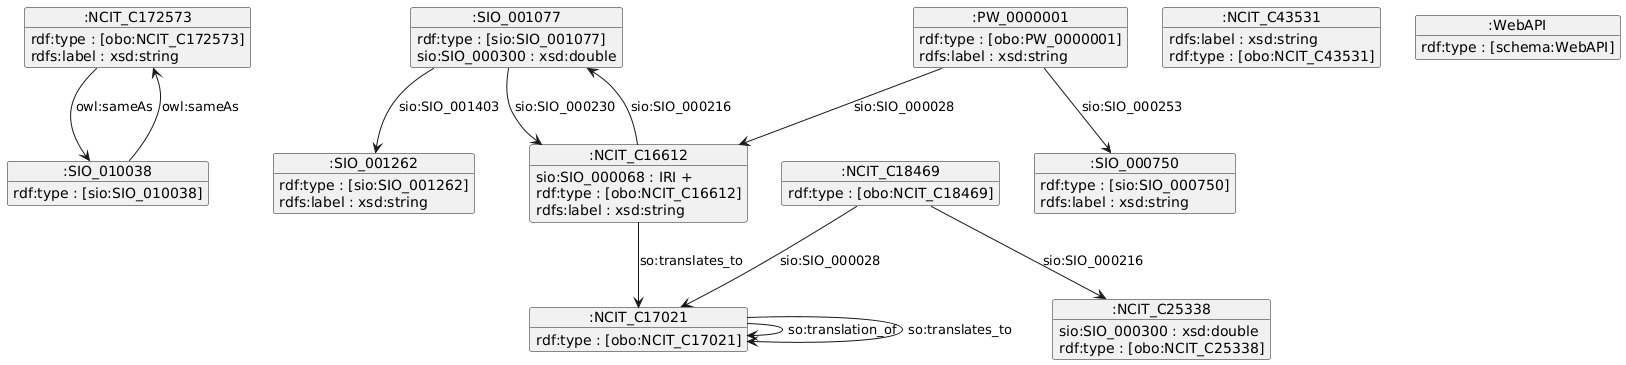

In [33]:
# Use without parameters (defaults)
# bdf.shacl()

# Or use with parameters
bdf.shacl(
    path=os.path.join(
        base_dir, "examples", "data", "gene_to_graph_workflow", "BDF_example_shacl.ttl"
    ),  # Set a path for TTL serialization
    threshold=0.001,
    uml_figure_path=os.path.join(
        base_dir, "examples", "data", "gene_to_graph_workflow", "BDF_example_shacl.png"
    ),  # Set a path for diagram
)

# Display the UML figure
display(
    Image(
        os.path.join(
            base_dir, "examples", "data", "gene_to_graph_workflow", "BDF_example_shacl.png"
        )
    )
)

- **ShEx**

PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX ex: <http://example.org/>
PREFIX weso-s: <http://weso.es/shapes/>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>
PREFIX owl: <http://www.w3.org/2002/07/owl#>
PREFIX obo: <http://purl.obolibrary.org/obo/>
PREFIX so: <http://purl.obolibrary.org/obo/so#>
PREFIX bdfo: <https://biodatafuse.org/onto/bdf#>
PREFIX minerva: <https://minerva-net.lcsb.uni.lu/api/>
PREFIX reactome: <https://reactome.org/content/detail/>
PREFIX uniprot: <https://www.uniprot.org/uniprotkb/>
PREFIX ensembl: <http://identifiers.org/ensembl#>
PREFIX graph: <https://biodatafuse.org/example/>
PREFIX brick: <https://brickschema.org/schema/Brick#>
PREFIX csvw: <http://www.w3.org/ns/csvw#>
PREFIX dc: <http://purl.org/dc/elements/1.1/>
PREFIX dcat: <http://www.w3.org/ns/dcat#>
PREFIX dcmitype: <http://purl.org/dc/dcmitype/>
PREFIX dcterms: <http://purl.org/dc/terms/>
PREFIX dcam: <http://purl.org/dc/dcam/>
PREFIX doap: <http://usefulinc.com/ns/doap#>
PREFIX fo

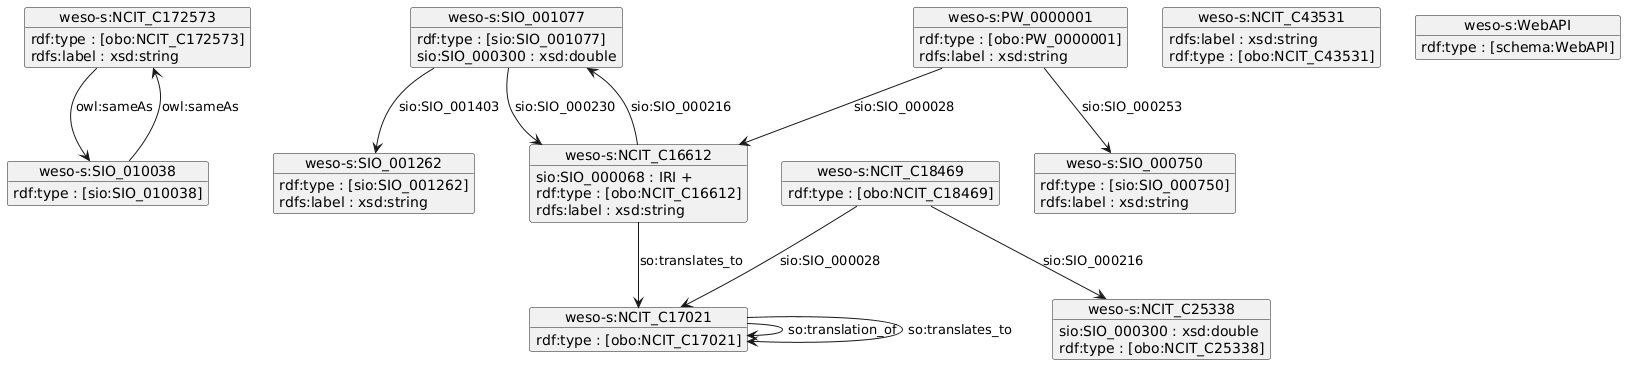

In [34]:
# Use without parameters (defaults)
# bdf.shex()

# Or use with parameters
bdf.shex(
    path=os.path.join(
        base_dir, "examples", "data", "gene_to_graph_workflow", "BDF_example_shex.ttl"
    ),  # Set a path for TTL serialization
    threshold=0.001,
    uml_figure_path=os.path.join(
        base_dir, "examples", "data", "gene_to_graph_workflow", "BDF_example_shex.png"
    ),  # Set a path for diagram
)

# Display the UML figure
display(
    Image(
        os.path.join(base_dir, "examples", "data", "gene_to_graph_workflow", "BDF_example_shex.png")
    )
)

Elapsed time for the workflow, if ran in block:

In [35]:
end_time = time.time()
elapsed_time = end_time - start_time
hours = elapsed_time // 3600
minutes = (elapsed_time % 3600) // 60
seconds = elapsed_time % 60
milliseconds = (elapsed_time % 1) * 1000

# Display elapsed time in h:m:s:ms
print(f"Elapsed Time: {int(hours)}h {int(minutes)}m {int(seconds)}s {int(milliseconds)}ms")

Elapsed Time: 0h 1m 4s 70ms


##### 8.5.3 Set up a virtuoso endpoint to query the RDF graph

[This repository](https://github.com/jmillanacosta/fast-virtuoso) provides a quick way to set up a local Virtuoso endpoint using its docker image.

Upload the prefixes (`bdf.shacl_prefixes(path="your/path")`) and the BDF graph generated above (`bdf.serialize("your/path", format="ttl")`).

In [36]:
# Define a function to send some sample SELECT queries and return the response in a pandas DataFrame
import requests


def send_sparql_query(query, endpoint="http://localhost:8899/sparql", format="text/csv"):
    headers = {"Accept": format}
    params = {"query": query}
    response = requests.get(endpoint, headers=headers, params=params)

    # Check if request was successful
    if response.status_code == 200:
        if format == "text/csv":
            # Convert CSV response to pandas DataFrame
            from io import StringIO

            csv_data = StringIO(response.text)
            return pd.read_csv(csv_data)
        else:
            return response.text  # For other formats if needed
    else:
        raise Exception(f"Query failed with status code {response.status_code}: {response.text}")

In [37]:
from rdflib import RDF, RDFS, SH, Graph

# Parse the query graph
# Load the graph
query_g = Graph()
with open("examples/SPARQL/queries.ttl", "r") as f:
    query_g.parse(f, format="turtle")

# Extract queries and comments into a list of dictionaries
queries_list = []
for s in query_g.subjects(RDF.type, SH.SPARQLSelectExecutable):
    query_text = query_g.value(s, SH.select)
    comment = query_g.value(s, RDFS.comment)

    if query_text and comment:
        # Append a dictionary for each query and its comment
        queries_list.append({"comment": comment.value, "query": query_text.value})

In [38]:
query_0 = send_sparql_query(queries_list[0]["query"])
print(queries_list[0]["comment"])
print(queries_list[0]["query"])
query_0

Retrieve details about each gene in the dataset, including the pathways it participates in, and the expression levels tied to it together with its associated anatomical entity and developmental stage. Return the text labels for all entities.

PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX sio: <http://semanticscience.org/resource/>
PREFIX obo: <http://purl.obolibrary.org/obo/>

SELECT ?gene ?geneLabel ?pathway ?pathwayLabel ?expressionMetric ?expressionValue ?anatomicalEntity ?anatomicalEntityLabel ?developmentalStage ?developmentalStageLabel
WHERE {
    ?gene a obo:NCIT_C16612 ;
          sio:SIO_000068 ?pathway ;
          sio:SIO_000216 ?expressionMetric ;
          rdfs:label ?geneLabel .
    ?anatomicalEntity rdfs:label ?anatomicalEntityLabel ;
          a sio:SIO_001262 .
    ?developmentalStage rdfs:label ?developmentalStageLabel ;
          a obo:NCIT_C43531 .
    ?expressionMetric sio:SIO_000300 ?expressionValue ;
          sio:SIO_001403 ?anatomicalEntity ;
     

,gene,geneLabel,pathway,pathwayLabel,expressionMetric,expressionValue,anatomicalEntity,anatomicalEntityLabel,developmentalStage,developmentalStageLabel


In [39]:
query_3 = send_sparql_query(queries_list[3]["query"])
print(queries_list[3]["query"])
print(queries_list[3]["comment"])
query_3


PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX sio: <http://semanticscience.org/resource/>
PREFIX obo: <http://purl.obolibrary.org/obo/>

SELECT ?gene ?geneLabel ?expressionValue ?anatomicalEntity ?entityLabel
WHERE {
    ?gene a obo:NCIT_C16612 ;
          sio:SIO_000216 ?expressionMetric ;
          rdfs:label ?geneLabel .

          
    ?expressionMetric a sio:SIO_001077 ;
                      sio:SIO_001403 ?anatomicalEntity ;
                      sio:SIO_000300 ?expressionValue ;
                      sio:SIO_001403 obo:UBERON_0000104 .
    ?anatomicalEntity a sio:SIO_001262 ;
                      rdfs:label ?anatomicalEntityLabel .
}
ORDER BY DESC(?expressionValue)
List genes linked to that have been found to be expressed in blood, along with their expression level values. Sort them in descending order according to their expression level values. Return all relevant labels.


,gene,geneLabel,expressionValue,anatomicalEntity,entityLabel
